# Carray memory profiling

<a id='go to index'></a>
Index:
  1. <a href='#Profiling carray'>Profiling carray</a>
  -  <a href='#Profiling carray iterators'>Profiling carray iterators</a>

In this part of the tutorial we will make use of the [ipython_memwatcher](https://github.com/FrancescAlted/ipython_memwatcher) to analyze the memory usage of the carray objects compared to Numpy arrays.

Please be aware that measuring memory consumption is a tricky thing, so if you are going to run this section of the notebook several times you might need to restart the IPython kernel.
If you see weird results or get confused, quit IPython and start a fresh shell; then run the fewest commands you need to understand how RAM is being used during the process.

<a id='Profiling carray'></a>
## Profiling carray
<a href='#go to index'>Go to index</a>

In [1]:
from ipython_memwatcher import MemWatcher
import numpy as np
import bcolz
import pandas as pd

In [2]:
N = 1e8
arange_results = {}
mw = MemWatcher()
mw.start_watching_memory()

In [2] used 0.035 MiB RAM in 0.001s, peaked 0.000 MiB above current, total RAM usage 76.766 MiB


Let's create a couple of big objects:

In [3]:
a = np.arange(N)

In [3] used 762.965 MiB RAM in 0.660s, peaked 0.000 MiB above current, total RAM usage 839.730 MiB


In [4]:
# Get some measurements from the last executed cell:
arange_results['numpy'] = mw.measurements.memory_delta

In [4] used 0.027 MiB RAM in 0.001s, peaked 0.004 MiB above current, total RAM usage 839.758 MiB


In [5]:
b = bcolz.arange(N)

In [5] used 19.852 MiB RAM in 0.792s, peaked 0.000 MiB above current, total RAM usage 859.609 MiB


In [6]:
# Get some measurements from the last executed cell:
arange_results['carray in-memory'] = mw.measurements.memory_delta

In [6] used 0.035 MiB RAM in 0.002s, peaked 0.000 MiB above current, total RAM usage 859.645 MiB


In [7]:
b_disk = bcolz.arange(N, rootdir='mydir', mode='w')

In [7] used 1.047 MiB RAM in 0.915s, peaked 0.000 MiB above current, total RAM usage 860.691 MiB


In [8]:
# Get some measurements from the last executed cell:
arange_results['carray on-disk'] = mw.measurements.memory_delta

In [8] used 0.000 MiB RAM in 0.001s, peaked 0.000 MiB above current, total RAM usage 860.691 MiB


{'numpy': 762.96484375, 'carray in-memory': 19.8515625, 'carray on-disk': 1.046875}


/home/faltet/miniconda/lib/python2.7/site-packages/matplotlib/font_manager.py:1287: UserWarning: findfont: Font family [u'monospace'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


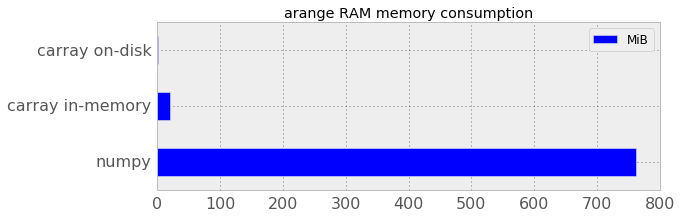

In [9]:
%matplotlib inline
mw.stop_watching_memory()

d = arange_results
print d

arange_results_df = pd.DataFrame({'MiB': arange_results.values()}, index=arange_results.keys())
pd.options.display.mpl_style = 'default'
arange_results_df.plot(kind='barh', figsize=(9,3), fontsize=16, title="arange RAM memory consumption")

In this example, the numpy array consumes aproximately what we would expect ~760 MB  (N items x 8bytes x 2^-20 factor MB). Due to the nature of our data set, default compression does already a pretty neat job, and the ammount of memory required by this object is much smaller, around 26 MB.

But a carray on-disk consumes only 0.2 MB, in this case our data resides on-disk using RAM only to keep references to that object, therefore as you see you can store huge amounts of information while treating them as if they were in-memory, carray on-disk and in-memory support exactly the same set of operations.

Compression ratios will highly depend on your data set, in case your data set would be highly random and you could not get good compression ratios, you could always use carray on disk to use as much less RAM as possible.

<a id='Profiling carray iterators'></a>
## Profiling carray iterators
<a href='#go to index'>Go to index</a>

Let's have a look now at some operations we already saw in this tutorial and check how much memory they actually consume:

In [10]:
sumif_results = {}
mw.start_watching_memory()

In [10] used 23.191 MiB RAM in 0.410s, peaked 0.000 MiB above current, total RAM usage 883.883 MiB


In [11]:
r = sum(v for v in a if v < 10)

In [11] used 0.039 MiB RAM in 33.393s, peaked 0.000 MiB above current, total RAM usage 883.922 MiB


In [12]:
# Get some measurements from the last executed cell:
sumif_results['numpy'] = mw.measurements.memory_delta

In [12] used 0.004 MiB RAM in 0.001s, peaked 0.000 MiB above current, total RAM usage 883.926 MiB


In [13]:
r =  sum(v for v in b if v < 10)

In [13] used 0.750 MiB RAM in 8.042s, peaked 1.785 MiB above current, total RAM usage 884.676 MiB


In [14]:
# Get some measurements from the last executed cell:
sumif_results['carray in-memory'] = mw.measurements.memory_delta

In [14] used 0.004 MiB RAM in 0.001s, peaked 0.000 MiB above current, total RAM usage 884.680 MiB


In [15]:
r =  sum(v for v in b_disk if v < 10)

In [15] used -0.320 MiB RAM in 7.686s, peaked 1.875 MiB above current, total RAM usage 884.359 MiB


In [16]:
# Get some measurements from the last executed cell:
sumif_results['carray on-disk'] = mw.measurements.memory_delta

In [16] used 0.008 MiB RAM in 0.002s, peaked 0.000 MiB above current, total RAM usage 884.367 MiB


{'numpy': 0.0390625, 'carray in-memory': 0.75, 'carray on-disk': -0.3203125}


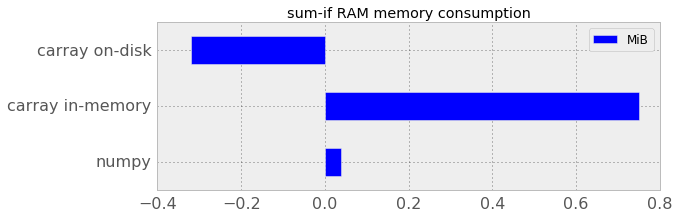

In [17]:
%matplotlib inline
mw.stop_watching_memory()
d = sumif_results
print d

sumif_df = pd.DataFrame({'MiB': d.values()}, index=d.keys())
pd.options.display.mpl_style = 'default'
sumif_df.plot(kind='barh', figsize=(9,3), fontsize=16, title="sum-if RAM memory consumption")

When you iterate `carray` objects, the iterator in this run actually *releases* memory for the in-memory case, whereas the on-disk one does require very little (sometimes negative?), but YMMV.

Again, measuring memory consumption is a tricky thing, so the take
away message is that you should not be afraid of using iterators because they are 1) memory efficient and 2) they are *fast*.